In [1]:
import sys
sys.path.append('..')
import tensorflow as tf
from trainer import utils
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('mimicknet.h5')

Instructions for updating:
Colocations handled automatically by placer.


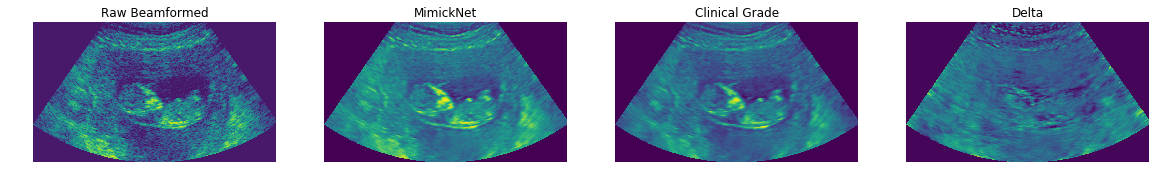

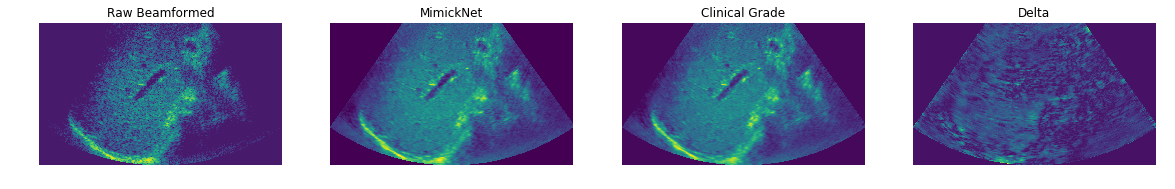

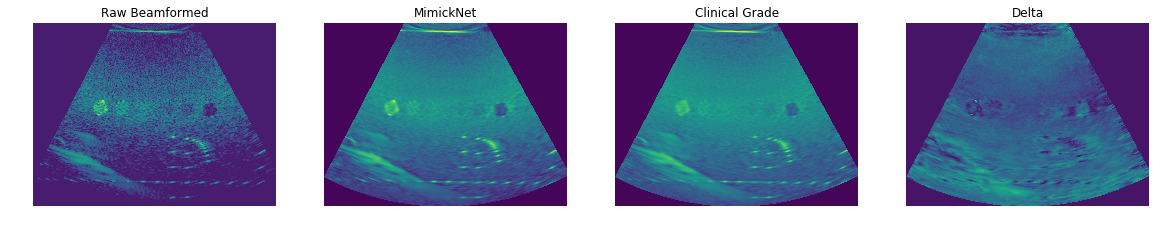

In [2]:
for file in ['fetal.mat', 'liver.mat', 'phantom.mat']:    
    # Load raw beamformed data and ground truth
    matfile = utils.loadmat(file)
    iq = np.abs(matfile['iq'])
    iq = 20*np.log10(iq/iq.max())
    gt = matfile['dtce']

    # Get raw beamformed image and ground truth image
    raw = np.clip(iq, -50, 0)
    raw = (raw-raw.min())/(raw.max() - raw.min())
    gt = (gt-gt.min())/(gt.max() - gt.min())
    
    # Prep Model inputs and get output
    iq = np.clip(iq, -100, 0)
    iq = (iq-iq.min())/(iq.max() - iq.min()) # Normalize to [0, 1]
    padded_iq, (original_height, original_width) = utils.make_shape(iq) # Pad data to be divisible by 16 
    padded_iq = padded_iq[None, :, :, None] # Reshape to be 4D [batch, height, width, 1]
    output = model.predict(padded_iq) # Run through the model 
    output = np.clip(output, 0, 1) # Clip to [0, 1]
    output = np.squeeze(output)[:original_height, :original_width] # Reshape to original size
    
    # Plot Figure
    fig, axes = plt.subplots(1,4, figsize=(20,20))
    axes[0].imshow(utils.scan_convert(raw, matfile['acq_params']))
    axes[0].set_title('Raw Beamformed')
    axes[0].axis('off')
    
    axes[1].imshow(utils.scan_convert(output, matfile['acq_params']))
    axes[1].set_title('MimickNet')
    axes[1].axis('off')
    
    axes[2].imshow(utils.scan_convert(matfile['dtce'], matfile['acq_params']))
    axes[2].set_title('Clinical Grade')
    axes[2].axis('off')
    
    axes[3].imshow(utils.scan_convert(np.abs(output-gt), matfile['acq_params']))
    axes[3].set_title('Delta')
    axes[3].axis('off')